In [16]:
%pylab inline
from astropy.cosmology import Planck13
from astropy.io import fits
from simqso.sqgrids import *
from simqso import sqbase
from simqso.sqrun import buildSpectraBulk,buildQsoSpectrum,save_spectra,load_spectra,restore_qso_grid
from simqso.sqmodels import BOSS_DR9_PLEpivot,get_BossDr9_model_vars

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/envs/elqs/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['convolve', 'norm', 'copy', 'hstack']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [17]:
# cover 1000A to 20um at R=1000
wave = sqbase.fixed_R_dispersion(1000,20e4,500)

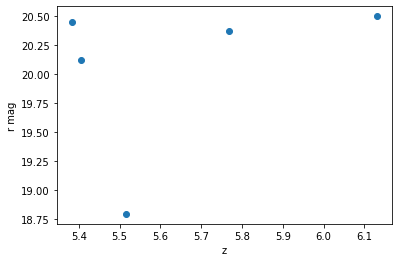

In [23]:
# just make up a few random redshifts between z=2 and z=3, then assign apparent mags according 
# to the BOSS DR9 QLF
nqso = 5
np.random.seed(12345)
zin = 2.0 + np.random.rand(nqso)
kcorr = sqbase.ContinuumKCorr('DECam-r',1450,effWaveBand='SDSS-r')
qsos = generateQlfPoints(BOSS_DR9_PLEpivot(cosmo=Planck13),
                         (17,22),(2.0,3.0),
                         kcorr=kcorr,zin=zin,
                         qlfseed=12345,gridseed=67890)
scatter(qsos.z,qsos.appMag)
xlabel('z')
ylabel('r mag');

In [24]:
# add the fiducial quasar SED model from BOSS DR9
# need to set forestseed if the forest transmission sightlines are to be reproducible
sedVars = get_BossDr9_model_vars(qsos,wave,0,forestseed=192837465,verbose=1)
qsos.addVars(sedVars)

Generating 5 sightlines


In [25]:
# define photometry in DECam and WISE systems
qsos.loadPhotoMap([('DECam','DECaLS'),('WISE','AllWISE')])

{'WISE-AllWISE-W1': <simqso.sqphoto.allwisePhotoUnc object at 0x7fd477a77588>, 'WISE-AllWISE-W2': <simqso.sqphoto.allwisePhotoUnc object at 0x7fd477a71e80>}


In [26]:
# ready to generate spectra. iteration is necessary to converge on the per-object k-correction,
# after two steps the maximum error on the absolute mags is <<1%
_,spectra = buildSpectraBulk(wave,qsos,saveSpectra=True,maxIter=3,verbose=10)

simulating  5  quasar spectra
units are  flux
buildSpectra iteration  1  out of  3
--> delta mag mean = 0.3678262, rms = 0.0610746, |max| = 0.4759182
buildSpectra iteration  2  out of  3
--> delta mag mean = -0.0045323, rms = 0.0023024, |max| = 0.0066166


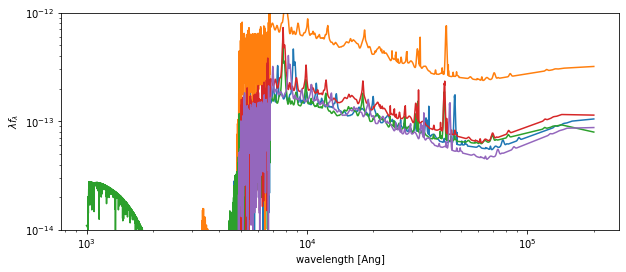

In [37]:
figure(figsize=(10,4))
plot(wave,(wave*spectra).transpose())
xscale('log')
yscale('log')
xlabel('wavelength [Ang]')
ylabel(r'$\lambda{f}_\lambda}$')
ylim(1e-14,1e-12);

In [34]:
# the parameter values for each spectrum
qsos.data

absMag,appMag,z,slopes [5],"emLines [69,3]",igmlos,synMag [5],synFlux [5]
float32,float32,float32,float32,float32,int32,float32,float32
-27.036907,20.496723,6.1296163,-1.441939 .. -1.2008951,629.0 .. 287.83502,0,22.053452 .. 18.803707,1.508756 .. 30.096567
-28.347746,18.793026,5.5163755,-1.2108783 .. -1.1161132,629.0 .. 283.2046,1,20.231087 .. 17.26251,8.082871 .. 124.45025
-26.673828,20.444983,5.383919,-1.6688824 .. -0.5481944,629.0 .. 284.06268,2,21.935999 .. 18.744455,1.6811268 .. 31.784657
-27.007206,20.115852,5.40456,-1.7053051 .. -0.96226186,629.0 .. 288.77643,3,21.945251 .. 18.599997,1.6668603 .. 36.30791
-26.945148,20.373112,5.767725,-1.6437544 .. -1.0495588,629.0 .. 314.29593,4,22.068007 .. 18.97146,1.488667 .. 25.787886


In [9]:
# save the simulation meta-data to a file
qsos.write('quickspeclib_meta',extname='quickspec',overwrite=True)

In [10]:
ff = fits.open('quickspeclib_meta.fits')
ff.info()

Filename: quickspeclib_meta.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  QUICKSPEC     1 BinTableHDU     66   5R x 8C   [E, E, E, 5E, 207E, J, 5E, 5E]   


In [11]:
# save the spectra to a fits bin table
save_spectra(wave,spectra,'quickspeclib')

In [12]:
# restore the spectra
wave,spec = load_spectra('quickspeclib')

In [13]:
# restore the simulation meta-data into a QsoSimObjects
qsos_restore = restore_qso_grid('quickspeclib_meta',wave,extname='quickspec')

[absMag]:  AbsMagVar(FixedSampler,restWave=1450)
[appMag]:  AppMagVar(FixedSampler,"DECam-r")
[z]:  RedshiftVar(FixedSampler)
[slopes]:  BrokenPowerLawContinuumVar(MultiDimVar(5),[1100.0, 5700.0, 9730.0, 22300.0])
[emLines]:  BossDr9EmissionLineTemplateVar(MultiDimVar(69))
[fetempl]:  FeTemplateVar(meta={'fwhm': 5000.0, 'scales': [(0, 1540, 0.5), (1540, 1680, 2.0), (1680, 1868, 1.6), (1868, 2140, 1.0), (2140, 3500, 1.0)], 'useopt': True})
[igmlos]:  HIAbsorptionVar(FixedSampler,meta=({'forest0': {'zrange': (0.0, 1.5), 'logNHrange': (12.0, 19.0), 'gamma': 0.2, 'beta': 1.55, 'B': 0.017, 'N0': 340.0, 'brange': (10.0, 100.0), 'bsig': 24.0}, 'forest1': {'zrange': (1.5, 4.6), 'logNHrange': (12.0, 14.5), 'gamma': 2.04, 'beta': 1.5, 'B': 0.0062, 'N0': 102.0, 'brange': (10.0, 100.0), 'bsig': 24.0}, 'forest2': {'zrange': (1.5, 4.6), 'logNHrange': (14.5, 17.5), 'gamma': 2.04, 'beta': 1.8, 'B': 0.0062, 'N0': 4.05, 'brange': (10.0, 100.0), 'bsig': 24.0}, 'forest3': {'zrange': (1.5, 4.6), 'logNHrang

AttributeError: no attribute _init_grid

In [ ]:
# rebuild a single quasar spectrum
spec0 = buildQsoSpectrum(wave,qsos_restore.cosmo,
                         qsos_restore.getVars(SpectralFeatureVar),
                         qsos_restore.data[0])

In [ ]:
# plot the original and restored spectra for comparison
figure(figsize=(12,4))
plot(wave,spectra[0],lw=1.4)
plot(wave,spec0.f_lambda,ls='--')
yscale('log')
ylim(3e-18,2e-16)
xlim(3400,5000);#1e4);

In [ ]:
# restore another spectrum
spec1 = buildQsoSpectrum(wave,qsos_restore.cosmo,
                         qsos_restore.getVars(SpectralFeatureVar),
                         qsos_restore.data[1])

In [ ]:
# and plot the comparison again
figure(figsize=(12,4))
plot(wave,spectra[1],lw=1.4)
plot(wave,spec1.f_lambda,ls='--')
yscale('log')
ylim(3e-17,10e-16)
xlim(3250,1e4);

In [ ]:
# rebuild all of the spectra
_,allspec = buildSpectraBulk(wave,qsos_restore)

In [ ]:
figure(figsize=(10,4))
plot(wave,(wave*spectra).transpose())
xscale('log')
yscale('log')
xlabel('wavelength [Ang]')
ylabel(r'$\lambda{f}_\lambda}$')
ylim(1e-14,1e-12);